In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random

from tqdm import tqdm
import sklearn as sk

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return mae, mse, r2


class baseline_model:
    """ Benchmark with the mean/median of the target variable """
    """ Ignore StandardScaler """
    def __init__(self, method: str = 'mean'):
        self.method = method # baseline method
        self.pred   = None   # predictions 
        
    def fit_baseline(self, train_input, train_target):
        if self.method == 'mean': self.pred = train_target.mean()
        elif self.method == 'median': self.pred = train_target.median()

    def get_pred(self, data):
        return np.tile(self.pred, (len(data), 1))

class linear_regression:
    """ Linear regression model """
    def __init__(self, method: str = 'linear', normalization: bool = True):
        self.method = method    # regression method
        self.normalization = normalization
        self.pred   = None # predictions
        self.model  = None # regression model
        self.scaler = None # standard scaler

    def fit_regress(self, train_input, train_target, normalization: bool = True, **kwargs):

        if self.method == 'linear': self.model = LinearRegression(**kwargs)
        elif self.method == 'lasso': self.model = Lasso(**kwargs)
        elif self.method == 'ridge': self.model = Ridge(**kwargs)
        elif self.method == 'elasticnet': self.model = ElasticNet(**kwargs)

        if self.normalization:
            self.scaler = StandardScaler()
            train_input = self.scaler.fit_transform(train_input) 

        self.model.fit(train_input, train_target) 

    def get_pred(self, data, normalization: bool = True):
        if self.model is None: raise ValueError("Model is not fitted yet")
        if self.normalization: 
            if self.scaler is None: raise ValueError("Standard scaler is not fitted yet")
            else: data = self.scaler.transform(data)

        return self.model.predict(data)

class random_forest:
    """ Random forest model """
    def __init__(self, normalization: bool = True): 
        self.pred   = None # predictions
        self.model  = None # regression model
        self.scaler = None # standard scaler 
        self.normalization = normalization
        
    def fit_forest(self, train_input, train_target, **kwargs):
        if self.normalization: 
            self.scaler = StandardScaler()
            transformed_train_input = self.scaler.fit_transform(train_input) 

        self.model = RandomForestRegressor(**kwargs)
        self.model.fit(transformed_train_input, train_target)
        self.importance = pd.DataFrame({'feature': train_input.columns, 'importance': self.model.feature_importances_}).sort_values(by='importance', ascending=False)
        
    def get_pred(self, input):
        if self.model is None: raise ValueError("Model is not fitted yet")
        if self.normalization: 
            if self.scaler is None: raise ValueError("Standard scaler is not fitted yet")
            else: input = self.scaler.transform(input)

        return self.model.predict(input)


class xgboost:
    """ XGBoost model """
    def __init__(self, normalization: bool = True):
        self.pred   = None # predictions
        self.model  = None # regression model
        self.scaler = None # standard scaler
        self.normalization = normalization

    def fit_xgboost(self, train_input, train_target, **kwargs):
        if self.normalization: 
            self.scaler = StandardScaler()
            transformed_train_input = self.scaler.fit_transform(train_input) 

        self.model = XGBRegressor(**kwargs)
        self.model.fit(transformed_train_input, train_target)

        


In [57]:
project_path = '/Users/k.choi/Documents/github/csiro_git'
data_path    = '/Users/k.choi/Documents/github/csiro_git/data'
img_path     = '/Users/k.choi/Documents/github/csiro_git/data/train'
test_path    = '/Users/k.choi/Documents/github/csiro_git/data/test'

train_df     = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df      = pd.read_csv(os.path.join(data_path, "test.csv"))
rcomp_df      = pd.read_csv(os.path.join(project_path + '/stats', "complete_df.csv"))

In [58]:
rcomp_df.columns

Index(['r_mean', 'r_median', 'r_std', 'g_mean', 'g_median', 'g_std', 'b_mean',
       'b_median', 'b_std', 'green_coverage', 'hue_mean', 'hue_std',
       'sat_mean', 'sat_std', 'val_mean', 'val_std', 'sobel_mean', 'sobel_std',
       'canny_mean', 'canny_std', 'binary_mean', 'binary_std', 'lbp_mean',
       'lbp_std', 'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5',
       'lbp_6', 'lbp_7', 'lbp_8', 'lbp_9', 'contrast', 'dissimilarity',
       'homogeneity', 'energy', 'glcm_corre', 'ASM', 'entropy', 'image_id',
       'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm',
       'Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g'],
      dtype='object')

In [59]:
state_encoder = LabelEncoder()
species_encoder = LabelEncoder()

comp_df = rcomp_df.copy()
comp_df['State'] = state_encoder.fit_transform(comp_df['State'])
comp_df['Species'] = species_encoder.fit_transform(comp_df['Species'])

print(' -- -- Species -- --' )
for i in np.unique(comp_df['Species']): print(i, species_encoder.inverse_transform([i]))
print(' -- -- State -- --' )
for i in np.unique(comp_df['State']): print(i, state_encoder.inverse_transform([i]))

 -- -- Species -- --
0 ['Clover']
1 ['Fescue']
2 ['Fescue_CrumbWeed']
3 ['Lucerne']
4 ['Mixed']
5 ['Phalaris']
6 ['Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed']
7 ['Phalaris_Clover']
8 ['Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass']
9 ['Phalaris_Ryegrass_Clover']
10 ['Ryegrass']
11 ['Ryegrass_Clover']
12 ['SubcloverDalkeith']
13 ['SubcloverLosa']
14 ['WhiteClover']
 -- -- State -- --
0 ['NSW']
1 ['Tas']
2 ['Vic']
3 ['WA']


In [60]:
ndata   = len(comp_df); ntrain  = int(ndata * 0.8)

comp_input = comp_df.drop(columns=['Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'image_id', 'Sampling_Date'])
comp_target = comp_df[['Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g']]

train_input   = comp_input.iloc[:ntrain]
train_target  = comp_target.iloc[:ntrain]
valid_input   = comp_input.iloc[ntrain:]
valid_target  = comp_target.iloc[ntrain:]

In [61]:
base_model = baseline_model()

for targets in comp_target.columns:
    base_model.fit_baseline(train_input, train_target[targets])
    valid_pred = base_model.get_pred(valid_input)

    mae, mse, r2 = metrics(valid_target[targets], valid_pred)
    print(f'{targets} baseline model')
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")


Dry_Total_g baseline model
MAE: 23.3776, MSE: 1185.7915, R2: -0.0024
Dry_Green_g baseline model
MAE: 21.8789, MSE: 1012.2834, R2: -0.0000
Dry_Dead_g baseline model
MAE: 9.0935, MSE: 138.4204, R2: -0.0254
Dry_Clover_g baseline model
MAE: 8.0708, MSE: 183.0005, R2: -0.0001
GDM_g baseline model
MAE: 21.9480, MSE: 954.1545, R2: -0.0000


In [62]:
methods = ['linear', 'lasso', 'ridge', 'elasticnet' ]

regression_results = []

for target in comp_target.columns:

    results = {}

    for method in methods:
        model = linear_regression(method = method)
        model.fit_regress(train_input, train_target[target])
        valid_pred = model.get_pred(valid_input)

        mae, mse, r2 = metrics(valid_target[target], valid_pred)
        results[method] = {'mae': mae, 'mse': mse, 'r2': r2, 'model': model}

    regression_results.append({ 'target': target, 'results': results })

    if False:
        print(f'{target} , {method} : regression model')
        print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

In [63]:
for result in regression_results:
    print(result['target'])
    display(pd.DataFrame(result['results']).drop(index=['model']))

Dry_Total_g


,linear,lasso,ridge,elasticnet
mae,17.086367,17.401222,15.669174,18.478431
mse,664.770226,641.948232,503.727542,724.851248
r2,0.438049,0.457341,0.574183,0.387261


Dry_Green_g


,linear,lasso,ridge,elasticnet
mae,12.01239,13.134579,11.201414,15.220405
mse,365.152307,421.262586,309.332275,564.268574
r2,0.639279,0.583849,0.694421,0.442578


Dry_Dead_g


,linear,lasso,ridge,elasticnet
mae,8.408994,8.496889,8.20983,8.501165
mse,120.812623,124.615925,112.19327,126.317803
r2,0.10503,0.076855,0.168881,0.064248


Dry_Clover_g


,linear,lasso,ridge,elasticnet
mae,6.573313,6.401114,6.537549,6.134213
mse,71.977204,112.267555,84.279784,107.063558
r2,0.606625,0.386427,0.539388,0.414869


GDM_g


,linear,lasso,ridge,elasticnet
mae,11.931155,13.117608,10.958345,13.935007
mse,389.839982,424.462694,288.475271,485.910118
r2,0.591416,0.555129,0.697655,0.490727


In [93]:
forest_models  = [] 
forest_results = [] 

params = { 'n_estimators': 400, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 2, 'random_state': 8964, 'n_jobs': -1 }

for target in comp_target.columns:
    forest_model = random_forest()
    forest_model.fit_forest(train_input, train_target[target], **params)

    mae, mse, r2 = metrics(valid_target[target], forest_model.get_pred(valid_input))
    forest_models.append({ 'target': target, 'model': forest_model })
    forest_results.append({ 'target': target, 'mae': mae, 'mse': mse, 'r2': r2 })


,target,mae,mse,r2
0,Dry_Total_g,13.218157,388.251202,0.671799
1,Dry_Green_g,9.789436,297.396578,0.706212
2,Dry_Dead_g,7.144183,85.973621,0.363114
3,Dry_Clover_g,4.501669,59.016530,0.677459
4,GDM_g,10.181947,293.291909,0.692606


0 Dry_Total_g
1 Dry_Green_g
2 Dry_Dead_g
3 Dry_Clover_g
4 GDM_g


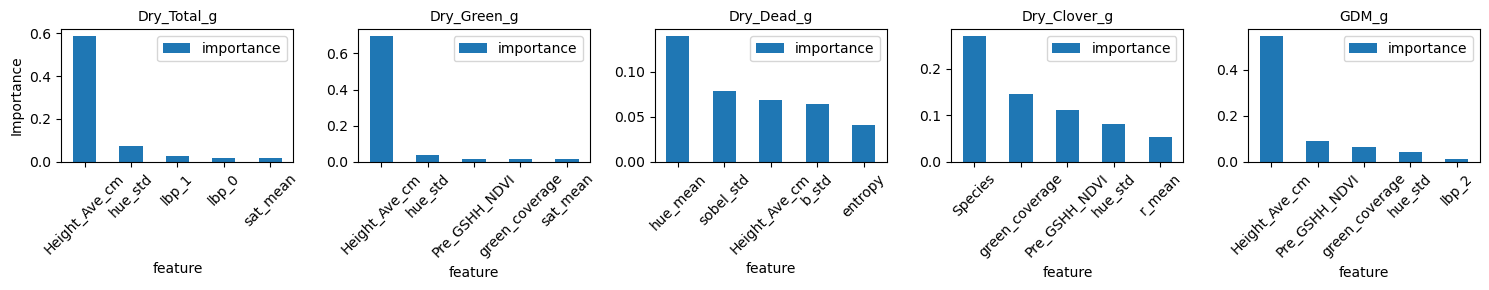

In [ ]:
display(pd.DataFrame(forest_results))

fig , axes = plt.subplots( 1, len(comp_target.columns), figsize=(3 * len(comp_target.columns), 3) )
for i, target in enumerate(comp_target.columns):
    print(i, target)
    forest_models[i]['model'].importance.head(5).plot(kind='bar', x='feature', y='importance', ax=axes[i])
    axes[i].set_xticklabels(forest_models[i]['model'].importance.head(5)['feature'], rotation=45)
    axes[i].set_title(f'{target}', fontsize=10)

axes[0].set_ylabel('Importance', fontsize=10)
plt.tight_layout();plt.show()

